In [588]:
import sys
print(sys.executable)

c:\Users\nickb\anaconda3\envs\dvd_rental\python.exe


In [589]:
import psycopg2
import pandas as pd

In [590]:
# establish a connection to your PostgreSQL database
conn = psycopg2.connect(
   database="DVDRental", 
   user="postgres", 
   password="C0l0rad01337!", 
   host="localhost", 
   port="5432"
)


# Queries

I will do multiple queries where row represents a distinct customer. After this is accomplished, the row are joined together, so that each row consists of important information on distinct customers. From here, model development will begin.

## Query 1: Customer Lifetime Value Spend

In [591]:
with open('customer_ltv.sql', 'r') as f:
    query = f.read()
    
with conn.cursor() as cur:
    cur.execute(query)
    results = cur.fetchall()
    columns = [desc[0] for desc in cur.description]  # get column names from cursor description

df = pd.DataFrame(results, columns=columns)
# conn.close()

In [592]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   customer_id   599 non-null    int64         
 1   recent_order  599 non-null    datetime64[ns]
 2   first_order   599 non-null    datetime64[ns]
 3   ltv_spend     599 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 18.8+ KB


In [593]:
# calculate the difference between the two columns in days and create a new column
df['days_from_recent_order_to_first_order'] = (df['recent_order'] - df['first_order']).dt.days

In [594]:
df.head()

,customer_id,recent_order,first_order,ltv_spend,days_from_recent_order_to_first_order
0,1,2007-04-30 01:10:44.996577,2007-02-14 23:22:38.996577,114.70,74
1,2,2007-04-30 21:08:19.996577,2007-02-17 19:23:24.996577,123.74,72
2,3,2007-04-30 20:14:12.996577,2007-02-16 00:02:31.996577,130.76,73
3,4,2007-04-30 17:26:26.996577,2007-02-15 07:59:54.996577,81.78,74
4,5,2007-05-14 13:44:29.996577,2007-02-15 20:31:40.996577,134.65,87


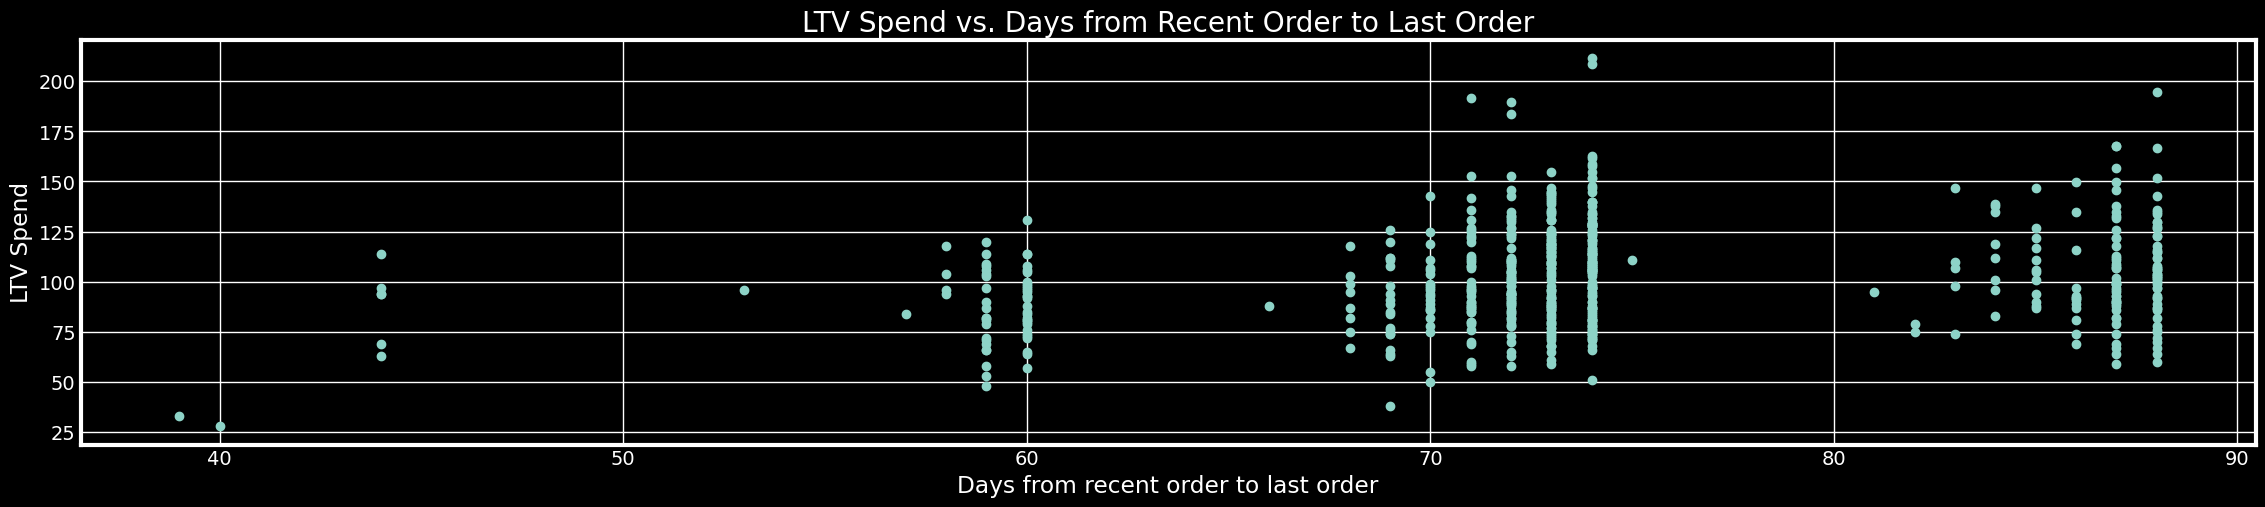

In [595]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(df['days_from_recent_order_to_first_order'], df['ltv_spend'], 'o')

# Add labels and title
plt.xlabel('Days from recent order to last order')
plt.ylabel('LTV Spend')
plt.title('LTV Spend vs. Days from Recent Order to Last Order')

# Show the plot
plt.show()


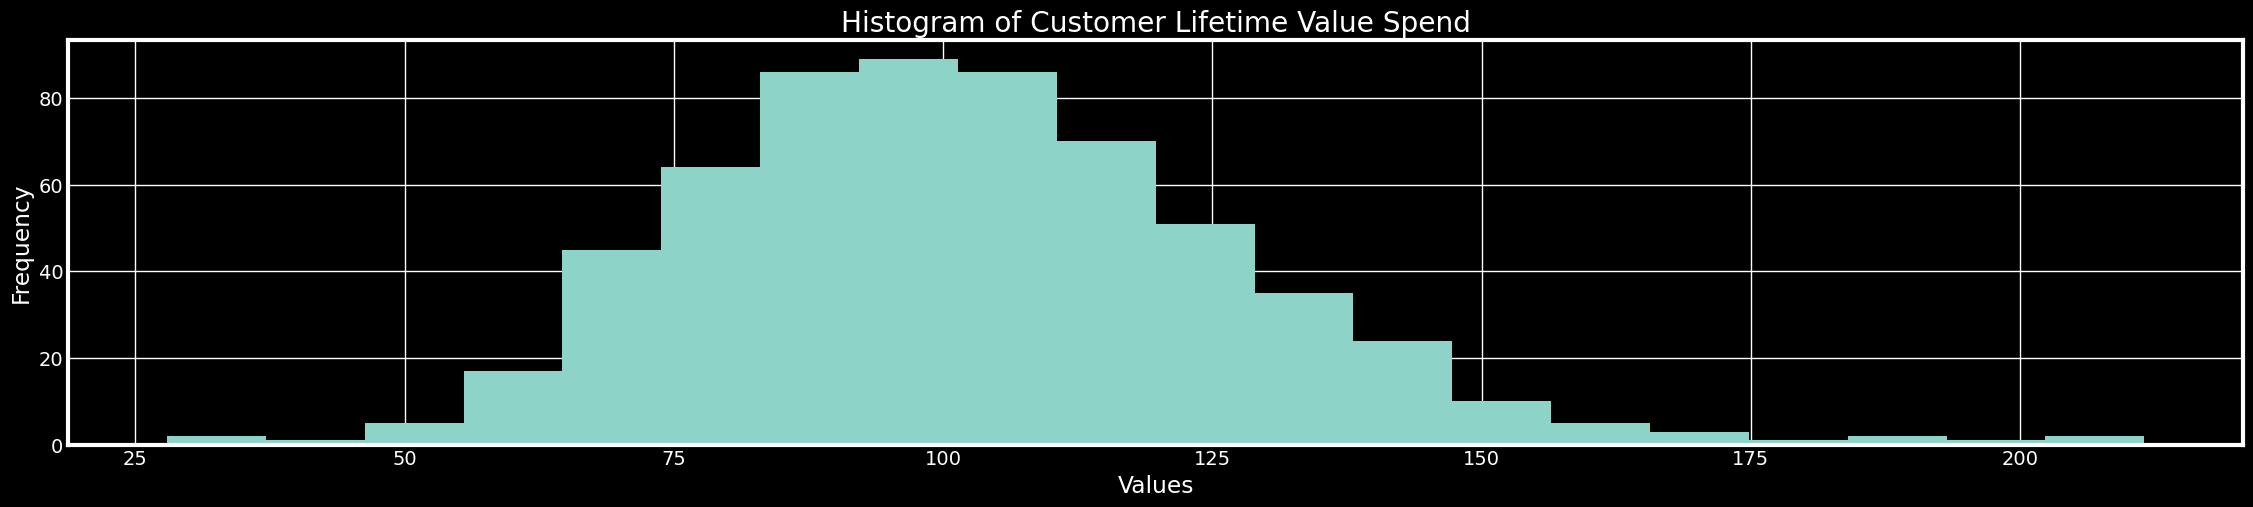

In [596]:
# Assuming your data is in a Pandas DataFrame called 'df' and the column is called 'my_column'
my_column_data = df['ltv_spend']

# Create a histogram with 20 bins using Matplotlib
plt.hist(my_column_data, bins=20)

# Add labels and title to the plot
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Customer Lifetime Value Spend')

# Display the plot
plt.show()

In [597]:
# Open a cursor to perform database operations
cur = conn.cursor()

# Execute a SQL query
cur.execute("SELECT * FROM customer_sources")

# Fetch the results of the query
results = cur.fetchall()

# Close the cursor and connection
# cur.close()
# conn.close()

# Process the query results
# for row in results:
#     print(row)

df_customer_source = pd.DataFrame(results, columns=['customer_id', 'source'])

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'google / cpc'),
  Text(1, 0, 'direct / none'),
  Text(2, 0, 'google / organic'),
  Text(3, 0, 'yelp / referral'),
  Text(4, 0, 'moviereviews / display'),
  Text(5, 0, 'bing / cpc')])

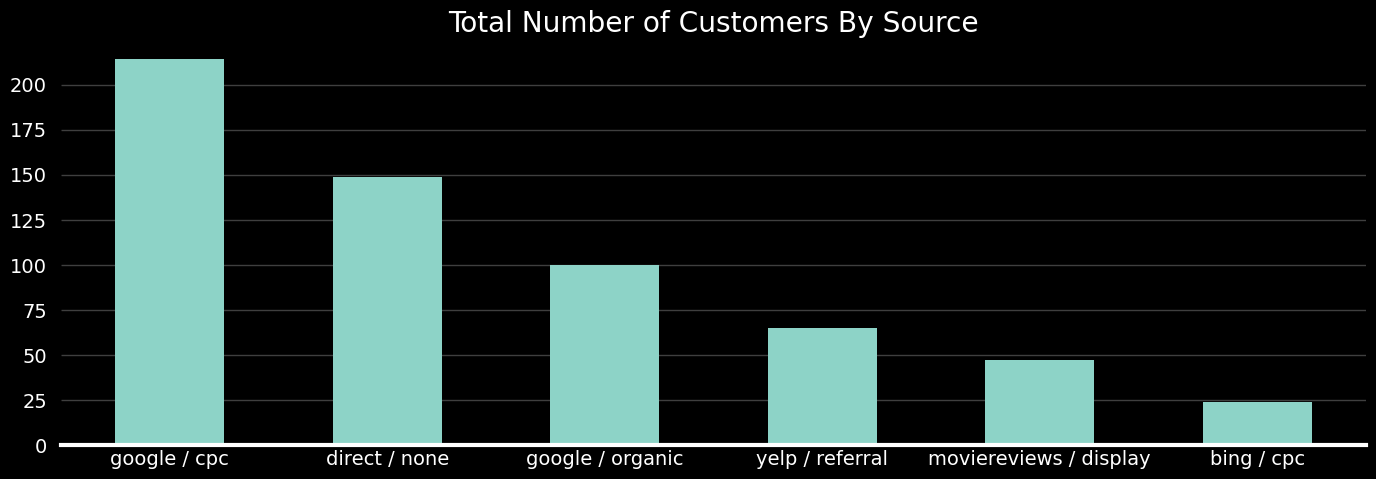

In [598]:
# Do a graph showing each source and the number of customers
df_customer_source['source'].value_counts().plot(kind='bar',title='Total Number of Customers By Source')

# Make the Title Total Number of Movie Rentals By Genre
plt.title('Total Number of Customers By Source')

# Make the X-Axis Labels More Readable
plt.xticks(rotation=0)

# Get Rid of Genre on the X-Axis
plt.xlabel('')

# Use a Different Color Palette
plt.style.use('dark_background')

# Make the grid lines less opaque
plt.grid(alpha=0.25)

# Remove the Vertical grid lines
plt.grid(axis='x')

#Give the Y-Axis Tickets A little more space to the left
plt.tick_params(axis='y', pad=10)

# Remove the Border on All Sides
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)

# Make the Size Slightly Smaller
plt.gcf().set_size_inches(15, 5)

# Make the x-axis text slightly smaller
plt.xticks(fontsize=14)

In [599]:
# Do One Hot Encoding for Each Source
df_customer_source = pd.get_dummies(df_customer_source, columns=['source'])

## Query 2: Customer's Preferred Movies by Rating

In [600]:
with open('customer_preferred_movie_rating_count.sql', 'r') as f:
    query = f.read()
    
with conn.cursor() as cur:
    cur.execute(query)
    results = cur.fetchall()
    columns = [desc[0] for desc in cur.description]  # get column names from cursor description

customer_pref_rating = pd.DataFrame(results, columns=columns)
# conn.close() # close the connection to the database... still grabbing SQL Queries, so commented out

In [601]:
customer_pref_rating.head()

,customer_id,rating,count
0,1,PG,9
1,1,NC-17,9
2,1,PG-13,6
3,1,R,5
4,1,G,3


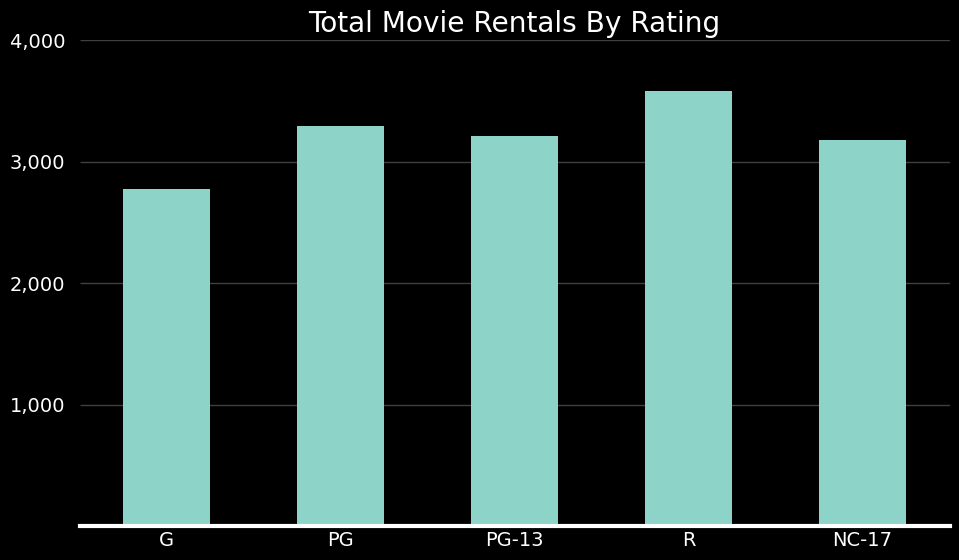

In [602]:
# Group By rating and count the number of movies in each rating category
grouped_ratings = customer_pref_rating.groupby('rating').sum()

# Create a bar chart of the grouped ratings with ratings on the x-axis and count on the y-axis
grouped_ratings.plot(kind='bar', y='count', title='Count of Movies by Rating')

# Add commas on y-axis and make the y-axis title total movies rented
plt.yticks([1000, 2000, 3000, 4000], ['1,000', '2,000', '3,000', '4,000'])

# Get Rid of the tooltip that says count
plt.gca().get_legend().remove()

# Make the Title Total Number of Movie Rentals By Genre
plt.title('Total Movie Rentals By Rating')

# Make the X-Axis Labels More Readable
plt.xticks(rotation=0)

# Get Rid of Genre on the X-Axis
plt.xlabel('')

# Use a Different Color Palette
plt.style.use('dark_background')
plt.xticks([0, 1, 2, 3, 4], ["G", "PG", "PG-13", "R", "NC-17"])

# Make the grid lines less opaque
plt.grid(alpha=0.25)

# Remove the Vertical grid lines
plt.grid(axis='x')

#Give the Y-Axis Tickets A little more space to the left
plt.tick_params(axis='y', pad=10)

# Remove the Border on All Sides
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)

# Make the Size Slightly Smaller
plt.gcf().set_size_inches(10, 6)

In [603]:
# pivot the DataFrame
df_pivot = customer_pref_rating.pivot(index='customer_id', columns='rating', values='count')


In [604]:
#reset the index
df_pivot = df_pivot.reset_index()

In [605]:
df_pivot

rating,customer_id,G,NC-17,PG,PG-13,R
0,1,3.0,9.0,9.0,6.0,5.0
1,2,4.0,6.0,6.0,7.0,4.0
2,3,6.0,1.0,2.0,5.0,12.0
3,4,7.0,1.0,5.0,5.0,4.0
4,5,3.0,8.0,10.0,8.0,9.0
...,...,...,...,...,...,...
594,595,4.0,4.0,7.0,9.0,6.0
595,596,3.0,8.0,6.0,6.0,5.0
596,597,3.0,4.0,6.0,4.0,8.0
597,598,7.0,NaN,5.0,5.0,5.0


## Query 3: Customer's Preferred Movies by Genre

In [606]:
with open('customer_film_genre.sql', 'r') as f:
    query = f.read()
    
with conn.cursor() as cur:
    cur.execute(query)
    results = cur.fetchall()
    columns = [desc[0] for desc in cur.description]  # get column names from cursor description

customer_pref_genre = pd.DataFrame(results, columns=columns)
conn.close()

In [607]:
customer_pref_genre.head()

,customer_id,genre,count
0,1,Drama,4
1,1,Action,2
2,1,Family,1
3,1,Documentary,1
4,1,Classics,6


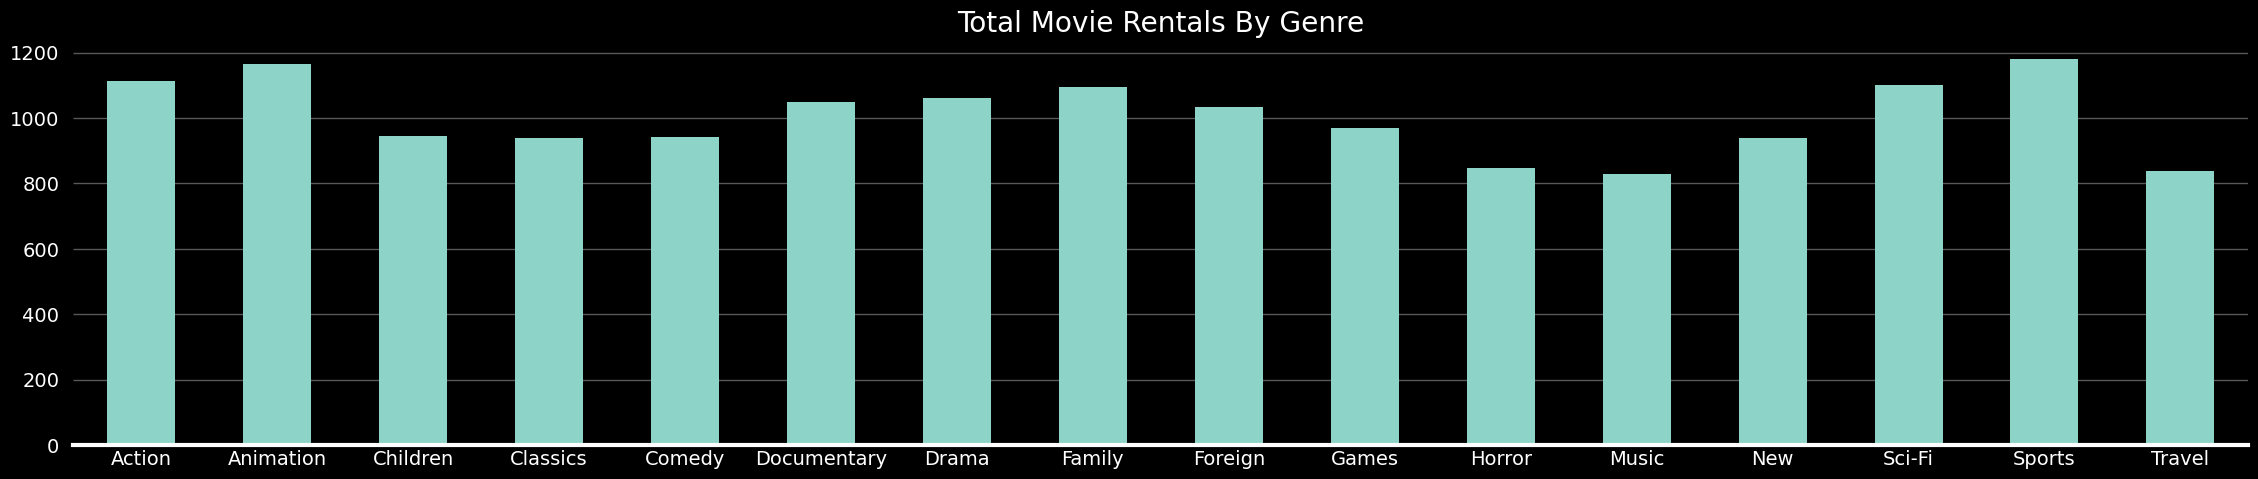

In [608]:
# Group By rating and count the number of movies in each rating category
grouped_genre = customer_pref_genre.groupby('genre').sum()

# Create a bar chart of the grouped ratings with ratings on the x-axis and count on the y-axis
grouped_genre.plot(kind='bar', y='count', title='Count of Movies by Genre')

# Get Rid of the tooltip that says count
plt.gca().get_legend().remove()

# Make the Title Total Number of Movie Rentals By Genre
plt.title('Total Movie Rentals By Genre')

# Make the X-Axis Labels More Readable
plt.xticks(rotation=0)

# Get Rid of Genre on the X-Axis
plt.xlabel('')

# Use a Different Color Palette
plt.style.use('dark_background')
# plt.xticks([0, 1, 2, 3, 4], ["G", "PG", "PG-13", "R", "NC-17"])

# Make the grid lines less opaque
plt.grid(alpha=0.35)

# Remove the Vertical grid lines
plt.grid(axis='x')

#Give the Y-Axis Tickets A little more space to the left
plt.tick_params(axis='y', pad=10)

# Remove the Border on All Sides
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)

# Make the Visual A Little Bigger
plt.rcParams['figure.figsize'] = [25, 5]


In [609]:
# pivot the DataFrame
df_genre_pivot = customer_pref_genre.pivot(index='customer_id', columns='genre', values='count')

#reset the index
df_genre_pivot = df_genre_pivot.reset_index()

In [610]:
df_genre_pivot.head()

genre,customer_id,Action,Animation,Children,Classics,Comedy,Documentary,Drama,Family,Foreign,Games,Horror,Music,New,Sci-Fi,Sports,Travel
0,1,2.0,2.0,NaN,6.0,5.0,1.0,4.0,1.0,1.0,1.0,NaN,2.0,2.0,2.0,2.0,1.0
1,2,3.0,3.0,1.0,4.0,NaN,1.0,NaN,1.0,1.0,2.0,NaN,1.0,2.0,1.0,5.0,2.0
2,3,4.0,3.0,NaN,1.0,2.0,1.0,1.0,1.0,NaN,2.0,2.0,2.0,2.0,3.0,2.0,NaN
3,4,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,NaN,3.0,NaN,1.0,2.0,2.0,2.0
4,5,1.0,6.0,2.0,7.0,1.0,1.0,1.0,4.0,1.0,3.0,2.0,2.0,3.0,NaN,3.0,1.0


In [611]:
# Besides customer_id, add up all the column values for a given row and create a new column called total movies watched
df_genre_pivot['total_movies_watched'] = df_genre_pivot.iloc[:, 1:].sum(axis=1)

In [612]:
df_genre_pivot.head()

genre,customer_id,Action,Animation,Children,Classics,Comedy,Documentary,Drama,Family,Foreign,Games,Horror,Music,New,Sci-Fi,Sports,Travel,total_movies_watched
0,1,2.0,2.0,NaN,6.0,5.0,1.0,4.0,1.0,1.0,1.0,NaN,2.0,2.0,2.0,2.0,1.0,32.0
1,2,3.0,3.0,1.0,4.0,NaN,1.0,NaN,1.0,1.0,2.0,NaN,1.0,2.0,1.0,5.0,2.0,27.0
2,3,4.0,3.0,NaN,1.0,2.0,1.0,1.0,1.0,NaN,2.0,2.0,2.0,2.0,3.0,2.0,NaN,26.0
3,4,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,NaN,3.0,NaN,1.0,2.0,2.0,2.0,22.0
4,5,1.0,6.0,2.0,7.0,1.0,1.0,1.0,4.0,1.0,3.0,2.0,2.0,3.0,NaN,3.0,1.0,38.0


In [613]:
# Divide each column by the total_movies_watched column
df_genre_pivot.iloc[:, 1:-1] = df_genre_pivot.iloc[:, 1:-1].div(df_genre_pivot['total_movies_watched'], axis=0)

In [614]:
df_genre_pivot.head()

genre,customer_id,Action,Animation,Children,Classics,Comedy,Documentary,Drama,Family,Foreign,Games,Horror,Music,New,Sci-Fi,Sports,Travel,total_movies_watched
0,1,0.062500,0.062500,NaN,0.187500,0.156250,0.031250,0.125000,0.031250,0.031250,0.031250,NaN,0.062500,0.062500,0.062500,0.062500,0.031250,32.0
1,2,0.111111,0.111111,0.037037,0.148148,NaN,0.037037,NaN,0.037037,0.037037,0.074074,NaN,0.037037,0.074074,0.037037,0.185185,0.074074,27.0
2,3,0.153846,0.115385,NaN,0.038462,0.076923,0.038462,0.038462,0.038462,NaN,0.076923,0.076923,0.076923,0.076923,0.115385,0.076923,NaN,26.0
3,4,0.045455,0.045455,0.045455,0.045455,0.090909,0.045455,0.090909,0.045455,0.090909,NaN,0.136364,NaN,0.045455,0.090909,0.090909,0.090909,22.0
4,5,0.026316,0.157895,0.052632,0.184211,0.026316,0.026316,0.026316,0.105263,0.026316,0.078947,0.052632,0.052632,0.078947,NaN,0.078947,0.026316,38.0


In [615]:
# Merge the two DataFrames
df_merged = pd.merge(df_pivot, df_genre_pivot, on='customer_id')

In [616]:
# Merge df_merged with df dataframe
df_final = pd.merge(df, df_merged, on='customer_id')

In [617]:
# Merge df_final with df_customer_source
df_final = pd.merge(df_final, df_customer_source, on='customer_id')

In [618]:
df_final.head()

,customer_id,recent_order,first_order,ltv_spend,days_from_recent_order_to_first_order,G,NC-17,PG,PG-13,R,...,Sci-Fi,Sports,Travel,total_movies_watched,source_bing / cpc,source_direct / none,source_google / cpc,source_google / organic,source_moviereviews / display,source_yelp / referral
0,1,2007-04-30 01:10:44.996577,2007-02-14 23:22:38.996577,114.70,74,3.0,9.0,9.0,6.0,5.0,...,0.062500,0.062500,0.031250,32.0,0,1,0,0,0,0
1,2,2007-04-30 21:08:19.996577,2007-02-17 19:23:24.996577,123.74,72,4.0,6.0,6.0,7.0,4.0,...,0.037037,0.185185,0.074074,27.0,0,1,0,0,0,0
2,3,2007-04-30 20:14:12.996577,2007-02-16 00:02:31.996577,130.76,73,6.0,1.0,2.0,5.0,12.0,...,0.115385,0.076923,NaN,26.0,0,0,0,1,0,0
3,4,2007-04-30 17:26:26.996577,2007-02-15 07:59:54.996577,81.78,74,7.0,1.0,5.0,5.0,4.0,...,0.090909,0.090909,0.090909,22.0,0,1,0,0,0,0
4,5,2007-05-14 13:44:29.996577,2007-02-15 20:31:40.996577,134.65,87,3.0,8.0,10.0,8.0,9.0,...,NaN,0.078947,0.026316,38.0,0,1,0,0,0,0


In [619]:
# Divide columns G, PG, PG-13, NC-17 and R by the total_movies_watched column
df_final.iloc[:, 5:10] = df_final.iloc[:, 5:10].div(df_final['total_movies_watched'], axis=0)

In [620]:
# Drop recent_order and first_order columns
df_final = df_final.drop(['recent_order', 'first_order'], axis=1)

In [621]:
# Drop customer_id column
df_final = df_final.drop(['customer_id'], axis=1)

# fill all the na values with 0
df_final = df_final.fillna(0)

In [622]:
df_final.head()

,ltv_spend,days_from_recent_order_to_first_order,G,NC-17,PG,PG-13,R,Action,Animation,Children,...,Sci-Fi,Sports,Travel,total_movies_watched,source_bing / cpc,source_direct / none,source_google / cpc,source_google / organic,source_moviereviews / display,source_yelp / referral
0,114.70,74,0.093750,0.281250,0.281250,0.187500,0.156250,0.062500,0.062500,0.000000,...,0.062500,0.062500,0.031250,32.0,0,1,0,0,0,0
1,123.74,72,0.148148,0.222222,0.222222,0.259259,0.148148,0.111111,0.111111,0.037037,...,0.037037,0.185185,0.074074,27.0,0,1,0,0,0,0
2,130.76,73,0.230769,0.038462,0.076923,0.192308,0.461538,0.153846,0.115385,0.000000,...,0.115385,0.076923,0.000000,26.0,0,0,0,1,0,0
3,81.78,74,0.318182,0.045455,0.227273,0.227273,0.181818,0.045455,0.045455,0.045455,...,0.090909,0.090909,0.090909,22.0,0,1,0,0,0,0
4,134.65,87,0.078947,0.210526,0.263158,0.210526,0.236842,0.026316,0.157895,0.052632,...,0.000000,0.078947,0.026316,38.0,0,1,0,0,0,0


In [623]:
# #  Select only the y-variable in the dataframe which is ltv spend
# y = df_final['ltv_spend']
# X = df_final.drop(['ltv_spend'], axis=1)

# # Convert y from object to float
# y = y.astype('float')

# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

# # Assuming X is your feature matrix and y is your target variable
# X_new = SelectKBest(chi2, k=10).fit_transform(X, y)

# # Print the selected feature indices
# print(SelectKBest(chi2, k=10).fit(X, y).get_support(indices=True))

In [624]:
# Data Preprocessing
# Import the necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Create a copy of the DataFrame
df_copy = df_final.copy()

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to the features and transform
scaled = scaler.fit_transform(df_copy)

# Convert the numpy array into a pandas DataFrame
scaled_df = pd.DataFrame(scaled, columns=df_copy.columns)

# Create the features and target DataFrames
X = scaled_df.drop('ltv_spend', axis=1)
y = scaled_df['ltv_spend']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Import the necessary libraries
from sklearn.linear_model import LinearRegression

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions using the testing data
predictions = model.predict(X_test)

# Import the necessary libraries
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the Mean Squared Error of our predictions
mse = mean_squared_error(y_test, predictions)

# Calculate the r-squared score
r2 = r2_score(y_test, predictions)

# Print the Mean Squared Error and r-squared score
print(f'MSE: {mse}, R2: {r2}')

MSE: 0.3509188773689124, R2: 0.631730238069143


### K-Means Implementation

In [625]:
# Implement a Clustering Algorithm
from sklearn.cluster import KMeans

# Create a KMeans instance with 3 clusters
model = KMeans(n_clusters=2)

# Fit the model to the data
model.fit(df_final)

# Get the cluster labels
labels = model.predict(df_final)

# Silhouette Score
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
print("silhouette score:", silhouette_score(df_final, labels))

# Calinski-Harabasz index, which is a measure of how well a data set has been clustered
from sklearn.metrics import calinski_harabasz_score

# Calculate the Calinski-Harabasz score
print("Calinski-Harabasz score:", calinski_harabasz_score(df_final, labels))

silhouette score: 0.46556651991831305
Calinski-Harabasz score: 722.6180061710949


c:\Users\nickb\anaconda3\envs\dvd_rental\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nickb\anaconda3\envs\dvd_rental\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


c:\Users\nickb\anaconda3\envs\dvd_rental\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nickb\anaconda3\envs\dvd_rental\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\nickb\anaconda3\envs\dvd_rental\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nickb\anaconda3\envs\dvd_rental\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks t

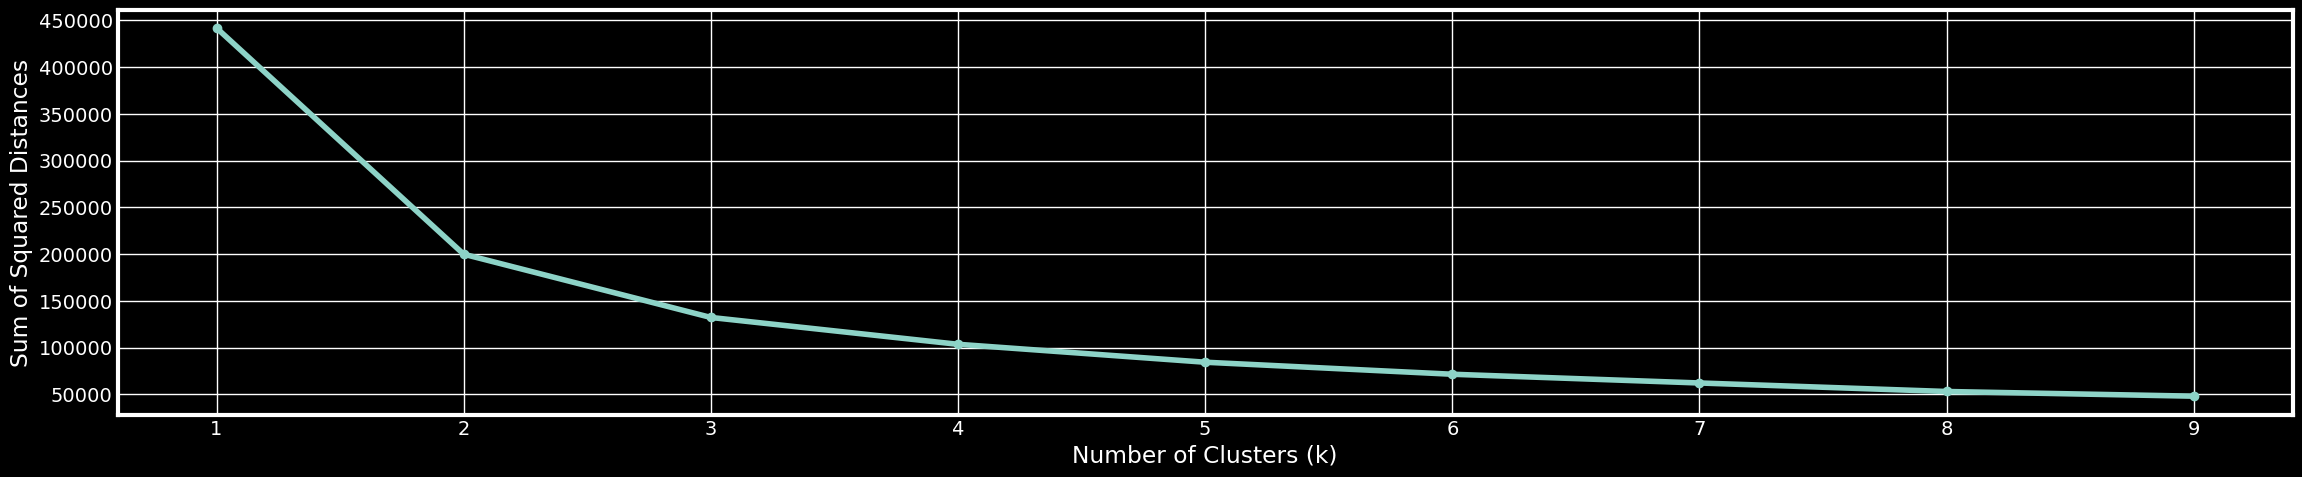

In [626]:
# Elbow Method
# Create an empty list to hold the SSE values
sse = []

# Create a list of k values to use in the loop
k_values = range(1, 10)

# Loop through the different k values and calculate the SSE for each
for k in k_values:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(df_final)
    
    # Append the inertia to the list of SSE
    sse.append(model.inertia_)

# Plot k_values vs sse
plt.plot(k_values, sse, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.xticks(k_values)
plt.show()


### Hierarchical Clustering

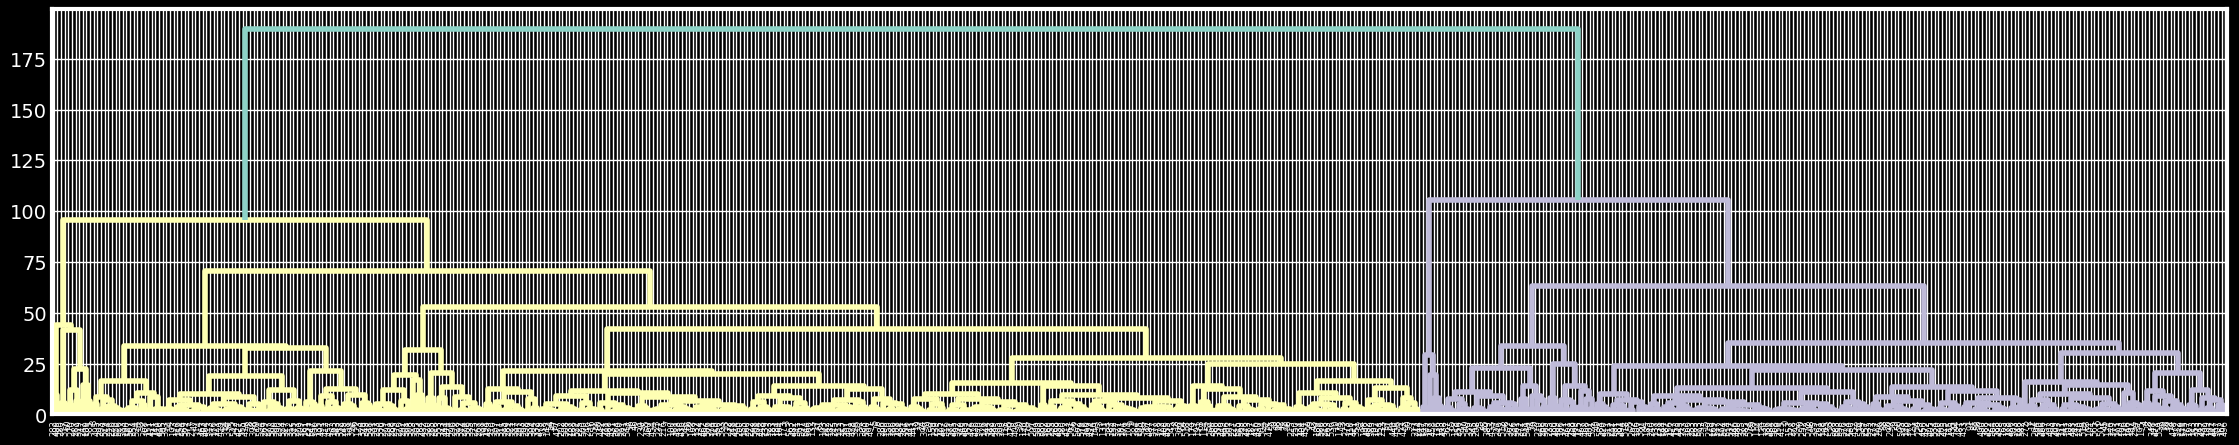

In [627]:
### hierarchical clustering

# Import the necessary libraries
from scipy.cluster.hierarchy import linkage, dendrogram

# Use the linkage() function to compute distance
mergings = linkage(df_final, method='complete')

# Plot the dendrogram, using varieties as labels
dendrogram(mergings,labels=df_final.index, leaf_rotation=90, leaf_font_size=6)

# Display the plot
plt.show()


### Agglomerative Clustering

In [628]:
# Import the necessary libraries
from sklearn.cluster import AgglomerativeClustering

# Create a AgglomerativeClustering instance with 3 clusters
model = AgglomerativeClustering(n_clusters=2)

# Fit the model to the data
model.fit(df_final)

# Get the cluster labels
labels = model.fit_predict(df_final)

# Calculate the silhouette score
print("silhouette score:", silhouette_score(df_final, labels))

# Calculate the Calinski-Harabasz score
print("Calinski-Harabasz score:", calinski_harabasz_score(df_final, labels))


silhouette score: 0.46724653859614523
Calinski-Harabasz score: 593.552403768621
